# LightGBM - Model Training and Optimization

This notebook trains and optimizes a LightGBM classifier for credit scoring.

## Overview
- **Part A**: Initial training with default/reasonable hyperparameters
- **Part B**: Hyperparameter tuning with Optuna (optimizing AUC)
- **Part C**: Final model evaluation and registration

## Methodology
1. **Cross-Validation**: 5-fold stratified CV for all evaluations
2. **Class Imbalance**: Handled via `scale_pos_weight`
3. **Metrics**: AUC (primary), Accuracy (control), Business Cost (final selection)
4. **Tracking**: All experiments logged to MLflow

## Business Context
- False Negative (FN): Missing a default → Cost = 10
- False Positive (FP): Rejecting a good client → Cost = 1
- Total Cost = 10 × FN + 1 × FP


## 1. Setup and Configuration


In [1]:
import sys
from pathlib import Path

# Add parent directory to path for imports
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import optuna
import mlflow
import warnings
warnings.filterwarnings('ignore')

# Project utilities
from src.utils.notebook_mlflow import (
    quick_mlflow_setup, NotebookMLFlow,
    FN_COST, FP_COST,
    calculate_business_cost, find_optimal_threshold
)
from src.utils.feature_io import load_data_splits

# Configuration
RANDOM_STATE = 42
N_FOLDS = 5
N_OPTUNA_TRIALS = 50  # Number of Optuna trials

print("Imports complete")
print(f"   Random State: {RANDOM_STATE}")
print(f"   CV Folds: {N_FOLDS}")
print(f"   Optuna Trials: {N_OPTUNA_TRIALS}")
print(f"   Business Cost: {FN_COST}×FN + {FP_COST}×FP")


Imports complete
   Random State: 42
   CV Folds: 5
   Optuna Trials: 50
   Business Cost: 10.0×FN + 1.0×FP


In [2]:
# Initialize MLflow tracker
mlflow_tracker = quick_mlflow_setup("credit-scoring-lightgbm")
print(" MLflow tracker ready")


2026/01/09 15:56:15 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/09 15:56:15 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


✅ MLFlow configuré - Expérience: credit-scoring-lightgbm
 MLflow tracker ready


## 2. Load Data Splits

Using the same splits created in `03_dummy_classifier.ipynb` for fair comparison.


In [3]:
# Load pre-created data splits (from 03_dummy_classifier.ipynb)
splits = load_data_splits(input_dir="../data/processed")

X_train = splits["X_train"]
y_train = splits["y_train"]
X_val = splits["X_val"]
y_val = splits["y_val"]
X_test = splits["X_test"]
y_test = splits["y_test"]
feature_names = splits["feature_names"]

# Calculate scale_pos_weight for imbalanced classes
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"\nTraining set: {len(X_train):,} samples ({y_train.mean():.2%} positive)")
print(f"Validation set: {len(X_val):,} samples ({y_val.mean():.2%} positive)")
print(f"Test set: {len(X_test):,} samples ({y_test.mean():.2%} positive) - RESERVED")
print(f"Number of features: {len(feature_names)}")
print(f"Scale pos weight: {scale_pos_weight:.2f}")


✅ Loaded data splits from: ../data/processed/data_splits.pkl
   Train: 184,503 samples
   Val:   61,502 samples
   Test:  61,502 samples

Training set: 184,503 samples (8.07% positive)
Validation set: 61,502 samples (8.07% positive)
Test set: 61,502 samples (8.07% positive) - RESERVED
Number of features: 763
Scale pos weight: 11.39


In [4]:
# Load baseline and RF metrics for comparison
baseline_path = Path("../data/processed/baseline_metrics.pkl")
rf_path = Path("../data/processed/rf_results.pkl")

if baseline_path.exists():
    with open(baseline_path, 'rb') as f:
        baseline_metrics = pickle.load(f)
    print(f" Baseline metrics loaded:")
    print(f"   Baseline AUC (stratified): {baseline_metrics['stratified']['cv_auc_mean']:.4f}")

if rf_path.exists():
    with open(rf_path, 'rb') as f:
        rf_results = pickle.load(f)
    print(f"\n Random Forest metrics loaded:")
    print(f"   RF Best AUC: {rf_results['best_cv_results']['cv_auc_mean']:.4f}")
    print(f"   RF Validation AUC: {rf_results['validation_metrics']['auc']:.4f}")


 Baseline metrics loaded:
   Baseline AUC (stratified): 0.4995

 Random Forest metrics loaded:
   RF Best AUC: 0.7354
   RF Validation AUC: 0.7362


---
# Part A: Initial Training (No Tuning)

Train LightGBM with reasonable default hyperparameters and evaluate with cross-validation.


In [7]:
# Define initial LightGBM model with reasonable defaults
lgbm_initial = LGBMClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

initial_params = {
    "n_estimators": 100,
    "max_depth": 8,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "min_child_samples": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": round(scale_pos_weight, 2),
    "random_state": RANDOM_STATE
}

print("Initial LightGBM Configuration:")
for param, value in initial_params.items():
    print(f"   {param}: {value}")


Initial LightGBM Configuration:
   n_estimators: 100
   max_depth: 8
   learning_rate: 0.1
   num_leaves: 31
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   scale_pos_weight: 11.39
   random_state: 42


In [8]:
# Run cross-validation on initial model
print("\n" + "="*60)
print("INITIAL MODEL CROSS-VALIDATION")
print("="*60)

initial_cv_results = mlflow_tracker.cross_validate_model(
    model=lgbm_initial,
    X=X_train,
    y=y_train,
    cv=N_FOLDS,
    model_name="LightGBM_initial",
    params=initial_params,
    tags={"optimization": "none", "stage": "initial"},
    log_to_mlflow=True,
    create_plots=True
)

print("\n Initial model cross-validation complete")



INITIAL MODEL CROSS-VALIDATION

CROSS-VALIDATION: LightGBM_initial (5 folds)
  Fold 1/5: AUC=0.7817, Acc=0.7368, Cost=18064 (10.8s)
  Fold 2/5: AUC=0.7817, Acc=0.7380, Cost=18183 (9.0s)
  Fold 3/5: AUC=0.7815, Acc=0.7394, Cost=18465 (9.2s)
  Fold 4/5: AUC=0.7720, Acc=0.7344, Cost=18603 (9.1s)
  Fold 5/5: AUC=0.7754, Acc=0.7311, Cost=18798 (9.5s)

RESULTS: LightGBM_initial
  AUC:           0.7785 ± 0.0040
  Accuracy:      0.7359 ± 0.0029
  Business Cost: 18422.6 ± 268.8
  Optimal Threshold: 0.495 (Cost: 92138.0)
  Training Time: 47.6s

✅ Logged to MLflow: LightGBM_initial

 Initial model cross-validation complete


In [9]:
# Compare with baseline and RF
print("\n" + "="*60)
print("COMPARISON WITH BASELINE AND RANDOM FOREST")
print("="*60)

if 'baseline_metrics' in dir():
    baseline_auc = baseline_metrics['stratified']['cv_auc_mean']
    print(f"\n📊 AUC Comparison:")
    print(f"   Baseline (stratified): {baseline_auc:.4f}")
    print(f"   LightGBM (initial):    {initial_cv_results['cv_auc_mean']:.4f}")
    
if 'rf_results' in dir():
    rf_auc = rf_results['best_cv_results']['cv_auc_mean']
    print(f"   Random Forest (best):  {rf_auc:.4f}")
    
    diff = initial_cv_results['cv_auc_mean'] - rf_auc
    print(f"\n   LightGBM vs RF: {diff:+.4f}")



COMPARISON WITH BASELINE AND RANDOM FOREST

📊 AUC Comparison:
   Baseline (stratified): 0.4995
   LightGBM (initial):    0.7785
   Random Forest (best):  0.7354

   LightGBM vs RF: +0.0431


---
# Part B: Hyperparameter Tuning with Optuna

Use Optuna to find optimal hyperparameters, optimizing for AUC.


In [10]:
# Define Optuna objective function for LightGBM
def lgbm_optuna_objective(trial):
    """Optuna objective function for LightGBM optimization with comprehensive metrics logging."""
    # Ensure all required imports are available (in case cell 1 wasn't re-executed)
    from sklearn.metrics import (
        roc_auc_score, accuracy_score, confusion_matrix,
        precision_score, recall_score, f1_score
    )
    # Import business cost functions (already imported in cell 1, but ensure availability)
    from src.utils.notebook_mlflow import calculate_business_cost, find_optimal_threshold
    
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    }
    
    # Create model
    model = LGBMClassifier(**params)
    
    # Perform cross-validation
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    business_costs = []
    
    # Stocker toutes les prédictions pour calculer le seuil optimal
    all_y_true = []
    all_y_pred_proba = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)  # Seuil par défaut pour métriques
        
        # Calculer métriques
        auc_scores.append(roc_auc_score(y_fold_val, y_pred_proba))
        accuracy_scores.append(accuracy_score(y_fold_val, y_pred))
        precision_scores.append(precision_score(y_fold_val, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_fold_val, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_fold_val, y_pred, zero_division=0))
        
        # Business cost
        business_costs.append(calculate_business_cost(y_fold_val, y_pred))
        
        # Accumuler pour seuil optimal
        all_y_true.extend(y_fold_val)
        all_y_pred_proba.extend(y_pred_proba)
    
    # Calculer métriques agrégées
    cv_auc_mean = np.mean(auc_scores)
    cv_auc_std = np.std(auc_scores)
    cv_accuracy_mean = np.mean(accuracy_scores)
    cv_precision_mean = np.mean(precision_scores)
    cv_recall_mean = np.mean(recall_scores)
    cv_f1_mean = np.mean(f1_scores)
    cv_business_cost_mean = np.mean(business_costs)
    
    # Calculer seuil optimal sur toutes les prédictions OOF
    all_y_true = np.array(all_y_true)
    all_y_pred_proba = np.array(all_y_pred_proba)
    optimal_threshold, optimal_cost = find_optimal_threshold(all_y_true, all_y_pred_proba)
    
    # Log chaque essai à MLflow avec toutes les métriques
    mlflow_tracker.log_optuna_trial(
        trial_number=trial.number,
        params=params,
        metrics={
            'cv_auc_mean': cv_auc_mean,
            'cv_auc_std': cv_auc_std,
            'cv_accuracy_mean': cv_accuracy_mean,
            'cv_precision_mean': cv_precision_mean,
            'cv_recall_mean': cv_recall_mean,
            'cv_f1_mean': cv_f1_mean,
            'cv_business_cost_mean': cv_business_cost_mean,
            'optimal_threshold': optimal_threshold,
            'optimal_business_cost': optimal_cost
        },
        model_name="LightGBM"
    )
    
    return cv_auc_mean  # Retourne la métrique à optimiser

print("✅ Optuna objective function defined")


✅ Optuna objective function defined


In [11]:
# Run Optuna optimization
print("\n" + "="*60)
print("OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*60)
print(f"Trials: {N_OPTUNA_TRIALS}")
print(f"Objective: Maximize AUC")
print("="*60)

# Create Optuna study
study = optuna.create_study(
    direction='maximize',
    study_name='LightGBM_optimization',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Optimize with progress bar
study.optimize(
    lgbm_optuna_objective,
    n_trials=N_OPTUNA_TRIALS,
    show_progress_bar=True
)

print(f"\n✅ Optimization complete!")
print(f"   Best AUC: {study.best_value:.4f}")
print(f"   Best trial: #{study.best_trial.number}")


[I 2026-01-09 11:01:21,352] A new study created in memory with name: LightGBM_optimization



OPTUNA HYPERPARAMETER OPTIMIZATION
Trials: 50
Objective: Maximize AUC


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-09 11:03:00,508] Trial 0 finished with value: 0.7645719691275883 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'num_leaves': 68, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469887, 'reg_lambda': 0.002570603566117596}. Best is trial 0 with value: 0.7645719691275883.
[I 2026-01-09 11:03:52,554] Trial 1 finished with value: 0.7712963884947385 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.27081608642499677, 'num_leaves': 87, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032189e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.7712963884947385.
[I 2026-01-09 11:05:02,171] Trial 2 finished with value: 0.7797397000238319 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'num_leaves': 31, 'min_chil

In [12]:
# Display best hyperparameters
print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)

best_params = study.best_params
for param, value in best_params.items():
    print(f"   {param}: {value}")

print(f"\n   Best CV AUC: {study.best_value:.4f}")



BEST HYPERPARAMETERS
   n_estimators: 462
   max_depth: 8
   learning_rate: 0.023494051357506786
   num_leaves: 41
   min_child_samples: 57
   subsample: 0.8547346594106416
   colsample_bytree: 0.6635342054825645
   reg_alpha: 0.16963460951831583
   reg_lambda: 5.604425039000106e-07

   Best CV AUC: 0.7836


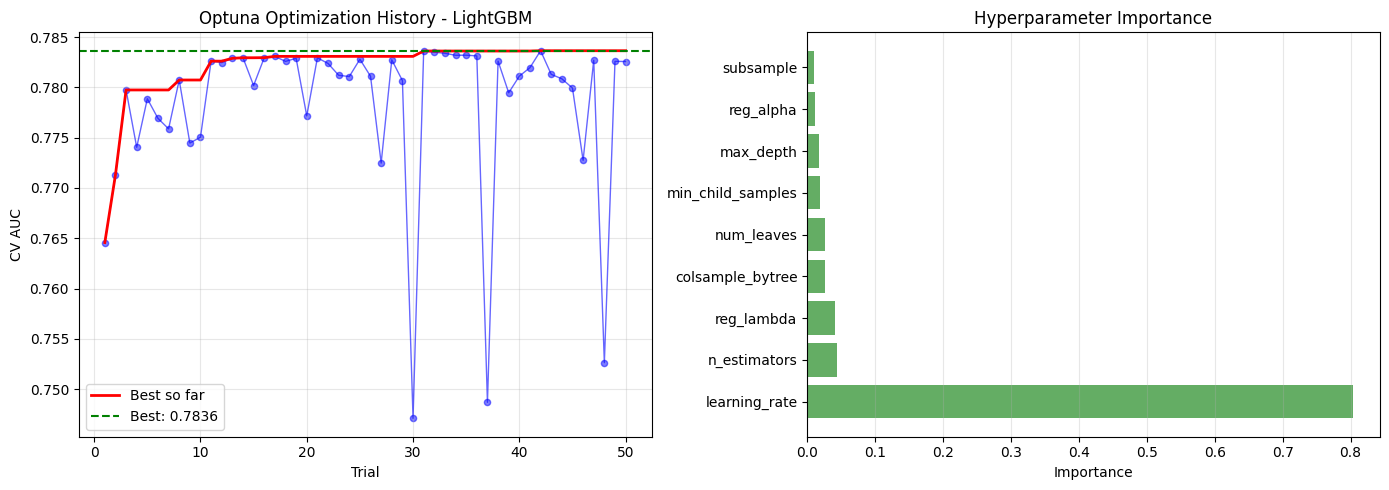


✅ Optimization plots saved


In [13]:
# Visualize Optuna optimization history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Optimization history
ax1 = axes[0]
trials = range(1, len(study.trials) + 1)
values = [t.value for t in study.trials]
ax1.plot(trials, values, 'b-', alpha=0.6, linewidth=1)
ax1.scatter(trials, values, c='blue', alpha=0.5, s=20)

# Best value line
best_values = [max(values[:i+1]) for i in range(len(values))]
ax1.plot(trials, best_values, 'r-', linewidth=2, label='Best so far')

ax1.axhline(y=study.best_value, color='green', linestyle='--', label=f'Best: {study.best_value:.4f}')
ax1.set_xlabel('Trial')
ax1.set_ylabel('CV AUC')
ax1.set_title('Optuna Optimization History - LightGBM')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Parameter importance
ax2 = axes[1]
param_importance = optuna.importance.get_param_importances(study)
params = list(param_importance.keys())
importances = list(param_importance.values())
ax2.barh(params, importances, color='forestgreen', alpha=0.7)
ax2.set_xlabel('Importance')
ax2.set_title('Hyperparameter Importance')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../data/processed/lgbm_optuna_optimization.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Optimization plots saved")


---
# Part C: Final Model Evaluation and Registration

Train the best model and evaluate on validation set.


In [9]:
import json

# Save best_params to JSON
# with open('../src/models/best_params_lightgbm.json', 'w') as f:
#     json.dump(best_params, f)

# Load best_params from JSON
with open('../src/models/best_params_lightgbm.json', 'r') as f:
    best_params = json.load(f)

best_params

{'n_estimators': 462,
 'max_depth': 8,
 'learning_rate': 0.023494051357506786,
 'num_leaves': 41,
 'min_child_samples': 57,
 'subsample': 0.8547346594106416,
 'colsample_bytree': 0.6635342054825645,
 'reg_alpha': 0.16963460951831583,
 'reg_lambda': 5.604425039000106e-07}

In [10]:
# Train best model with optimized hyperparameters
print("\n" + "="*60)
print("TRAINING BEST MODEL")
print("="*60)

# Add fixed parameters
best_params_full = {
    **best_params, 
    'scale_pos_weight': scale_pos_weight, 
    'random_state': RANDOM_STATE, 
    'n_jobs': -1,
    'verbose': -1
}

# Create and train best model
lgbm_best = LGBMClassifier(**best_params_full)

# Run CV with best params for final metrics
best_cv_results = mlflow_tracker.cross_validate_model(
    model=lgbm_best,
    X=X_train,
    y=y_train,
    cv=N_FOLDS,
    model_name="LightGBM_best",
    params={k: v for k, v in best_params_full.items() if k != 'verbose'},
    tags={"optimization": "optuna", "stage": "best"},
    log_to_mlflow=True,
    create_plots=True
)

print("\n✅ Best model cross-validation complete")



TRAINING BEST MODEL

CROSS-VALIDATION: LightGBM_best (5 folds)
  Fold 1/5: AUC=0.7867, Acc=0.7532, Cost=17917 (34.9s)
  Fold 2/5: AUC=0.7866, Acc=0.7559, Cost=18015 (33.0s)
  Fold 3/5: AUC=0.7878, Acc=0.7573, Cost=18073 (33.5s)
  Fold 4/5: AUC=0.7780, Acc=0.7526, Cost=18346 (32.1s)
  Fold 5/5: AUC=0.7792, Acc=0.7491, Cost=18629 (32.7s)

RESULTS: LightGBM_best
  AUC:           0.7836 ± 0.0042
  Accuracy:      0.7536 ± 0.0029
  Business Cost: 18196.0 ± 259.1
  Optimal Threshold: 0.475 (Cost: 90748.0)
  Training Time: 166.4s

✅ Logged to MLflow: LightGBM_best

✅ Best model cross-validation complete


feature importance

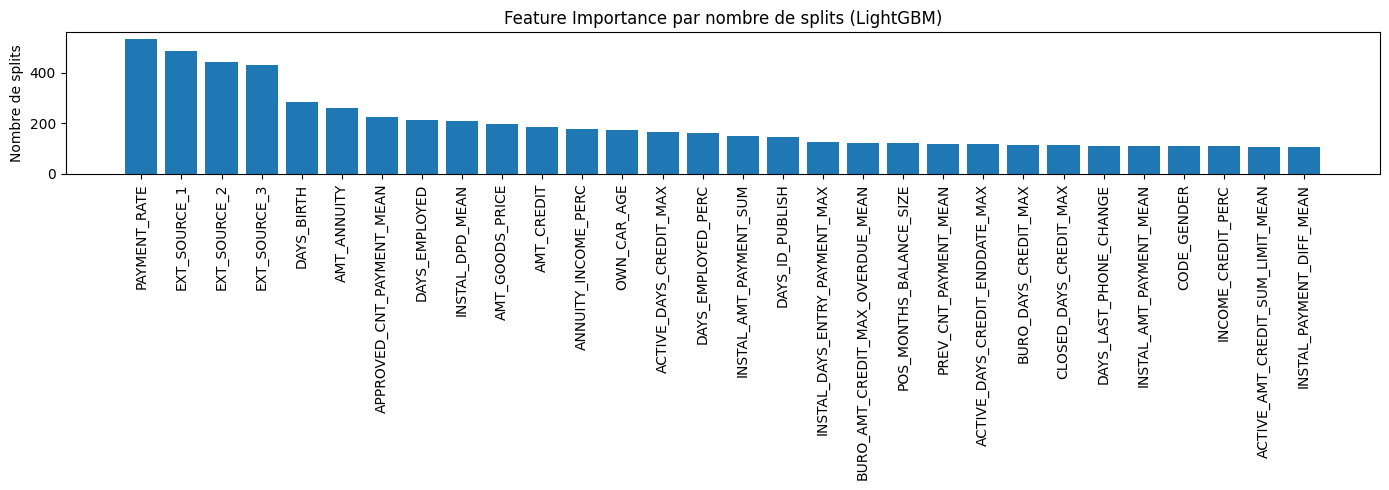


Top 20 variables par nombre de splits :


,feature,nb_splits
244,PAYMENT_RATE,533
30,EXT_SOURCE_1,486
31,EXT_SOURCE_2,443
32,EXT_SOURCE_3,431
9,DAYS_BIRTH,283
6,AMT_ANNUITY,260
578,APPROVED_CNT_PAYMENT_MEAN,224
10,DAYS_EMPLOYED,214
630,INSTAL_DPD_MEAN,209
7,AMT_GOODS_PRICE,197


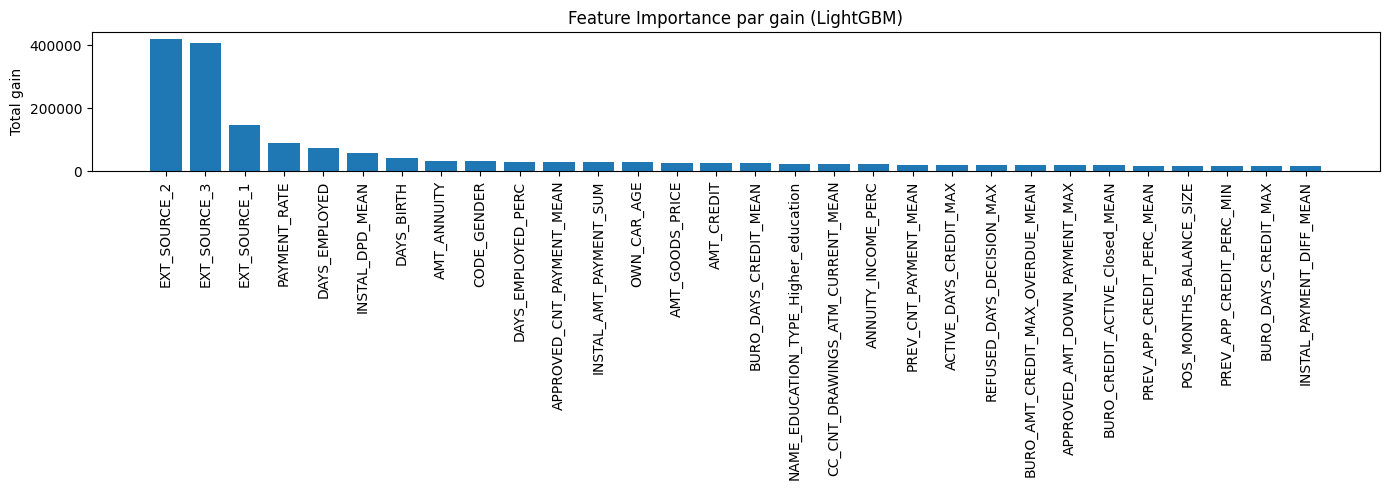


Top 20 variables par importance de gain :


,feature,gain_importance
31,EXT_SOURCE_2,420334.070040
32,EXT_SOURCE_3,408835.323982
30,EXT_SOURCE_1,147207.185059
244,PAYMENT_RATE,90333.086029
10,DAYS_EMPLOYED,73431.620729
630,INSTAL_DPD_MEAN,56018.471462
9,DAYS_BIRTH,41389.028538
6,AMT_ANNUITY,32708.022690
0,CODE_GENDER,30897.412502
240,DAYS_EMPLOYED_PERC,30014.977917


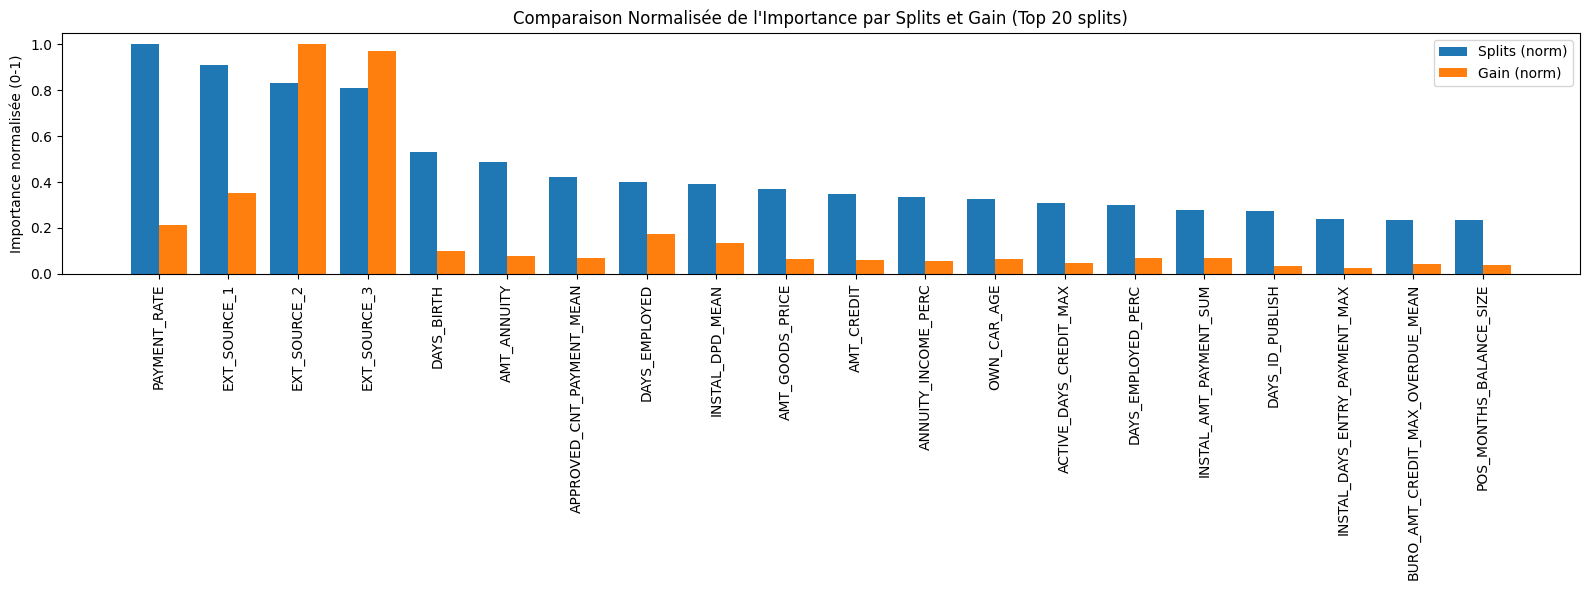


Corrélation de Spearman entre nb_splits et gain_importance: 0.993 (p=0.00e+00)

Note :
 - Les features en tête par nombre de splits ne sont pas toujours en tête par gain.
 - Les splits mesurent la fréquence d'utilisation dans les arbres ; le gain mesure la valeur ajoutée à chaque split.
Un feature utilisé très souvent mais avec un gain faible peut indiquer une variable très utile pour des séparations fines ou sur-représentée dans des décisions marginales.


In [24]:
# Analyse des features les plus utilisées par nombre de splits (split importance)

if hasattr(lgbm_best, "booster_"):
    booster = lgbm_best.booster_
else:
    booster = lgbm_best

# 1. Split importance (nombre de splits)
split_importances = booster.feature_importance(importance_type="split")
split_feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'nb_splits': split_importances
}).sort_values('nb_splits', ascending=False)

plt.figure(figsize=(14, 5))
plt.title("Feature Importance par nombre de splits (LightGBM)")
plt.bar(range(30), split_feat_imp_df['nb_splits'].values[:30])
plt.xticks(range(30), split_feat_imp_df['feature'].values[:30], rotation=90)
plt.ylabel("Nombre de splits")
plt.tight_layout()
plt.show()

print("\nTop 20 variables par nombre de splits :")
display(split_feat_imp_df.head(20))

# 2. Gain importance (importance basée sur la réduction de l'impureté)
gain_importances = booster.feature_importance(importance_type="gain")
gain_feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'gain_importance': gain_importances
}).sort_values('gain_importance', ascending=False)

plt.figure(figsize=(14, 5))
plt.title("Feature Importance par gain (LightGBM)")
plt.bar(range(30), gain_feat_imp_df['gain_importance'].values[:30])
plt.xticks(range(30), gain_feat_imp_df['feature'].values[:30], rotation=90)
plt.ylabel("Total gain")
plt.tight_layout()
plt.show()

print("\nTop 20 variables par importance de gain :")
display(gain_feat_imp_df.head(20))

# 3. Comparatif splits vs gain
comp_df = split_feat_imp_df[['feature', 'nb_splits']].merge(
    gain_feat_imp_df[['feature', 'gain_importance']], on="feature"
)

# Normalisons pour mieux visualiser la différence sur un même axe
comp_df['nb_splits_norm'] = comp_df['nb_splits'] / comp_df['nb_splits'].max()
comp_df['gain_importance_norm'] = comp_df['gain_importance'] / (comp_df['gain_importance'].max() + 1e-9)

plt.figure(figsize=(16, 6))
plt.title("Comparaison Normalisée de l'Importance par Splits et Gain (Top 20 splits)")
top_features = comp_df.sort_values('nb_splits', ascending=False).head(20)
plt.bar(np.arange(20)-0.2, top_features['nb_splits_norm'], width=0.4, label="Splits (norm)")
plt.bar(np.arange(20)+0.2, top_features['gain_importance_norm'], width=0.4, label="Gain (norm)")
plt.xticks(range(20), top_features['feature'], rotation=90)
plt.legend()
plt.ylabel("Importance normalisée (0-1)")
plt.tight_layout()
plt.show()

# 4. Corrélation entre splits et gain
from scipy.stats import spearmanr
corr, p = spearmanr(comp_df['nb_splits'], comp_df['gain_importance'])
print(f"\nCorrélation de Spearman entre nb_splits et gain_importance: {corr:.3f} (p={p:.2e})")

# 5. Discussion
print("\nNote :")
print(" - Les features en tête par nombre de splits ne sont pas toujours en tête par gain.")
print(" - Les splits mesurent la fréquence d'utilisation dans les arbres ; le gain mesure la valeur ajoutée à chaque split.")
print("Un feature utilisé très souvent mais avec un gain faible peut indiquer une variable très utile pour des séparations fines ou sur-représentée dans des décisions marginales.")



In [11]:
# Evaluate on validation set
print("\n" + "="*60)
print("VALIDATION SET EVALUATION")
print("="*60)

# Train on full training set
lgbm_best.fit(X_train, y_train)

# Predict on validation set
y_val_pred_proba = lgbm_best.predict_proba(X_val)[:, 1]

# on utilise le optimal treshold utiliser durant la CV
optimal_threshold = best_cv_results['optimal_threshold']
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics
val_auc = roc_auc_score(y_val, y_val_pred_proba)
val_acc = accuracy_score(y_val, y_val_pred)
val_cost = calculate_business_cost(y_val, y_val_pred)

print(f"\n Validation Set Results:")
print(f"   AUC:              {val_auc:.4f}")
print(f"   Accuracy:         {val_acc:.4f}")
print(f"   Business Cost:    {val_cost:.1f}")
print(f"   Optimal Threshold: {optimal_threshold:.3f}")



VALIDATION SET EVALUATION

 Validation Set Results:
   AUC:              0.7840
   Accuracy:         0.7242
   Business Cost:    30238.0
   Optimal Threshold: 0.475


In [ ]:
# Compare with Random Forest
print("\n" + "="*60)
print("COMPARISON: LightGBM vs Random Forest")
print("="*60)

if 'rf_results' in dir():
    rf_val = rf_results['validation_metrics']
    
    print(f"\n{'Metric':<20} {'Random Forest':<15} {'LightGBM':<15} {'Winner':<15}")
    print("-" * 65)
    
    # AUC
    auc_winner = "LightGBM" if val_auc > rf_val['auc'] else "Random Forest"
    print(f"{'AUC':<20} {rf_val['auc']:<15.4f} {val_auc:<15.4f} {auc_winner:<15}")
    
    # Accuracy
    acc_winner = "LightGBM" if val_acc > rf_val['accuracy'] else "Random Forest"
    print(f"{'Accuracy':<20} {rf_val['accuracy']:<15.4f} {val_acc:<15.4f} {acc_winner:<15}")
    
    # Business Cost (lower is better)
    cost_winner = "LightGBM" if val_cost < rf_val['business_cost'] else "Random Forest"
    print(f"{'Business Cost':<20} {rf_val['business_cost']:<15.1f} {val_cost:<15.1f} {cost_winner:<15}")
    



COMPARISON: LightGBM vs Random Forest

Metric               Random Forest   LightGBM        Winner         
-----------------------------------------------------------------
AUC                  0.7362          0.7840          LightGBM       
Accuracy             0.7511          0.7242          Random Forest  
Business Cost        34434.0         30238.0         LightGBM       


In [ ]:
# Register best model in MLflow
print("\n" + "="*60)
print("MODEL REGISTRATION")
print("="*60)

run_id = mlflow_tracker.log_best_model(
    model=lgbm_best,
    model_name="LightGBM",
    X_train=X_train,
    y_train=y_train,
    best_params={k: v for k, v in best_params_full.items() if k != 'verbose'},
    cv_results=best_cv_results,
    tags={"framework": "lightgbm", "final_model": "true"}
)



MODEL REGISTRATION


2026/01/09 16:16:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 16:17:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2026/01/09 16:17:00 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/09 16:17:00 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.



✅ Best model logged to MLflow
   Run ID: 973f518fdca246a0bf9bd93eb9b2c974
   Model URI: runs:/973f518fdca246a0bf9bd93eb9b2c974/model


Registered model 'LightGBM_best' already exists. Creating a new version of this model...
Created version '3' of model 'LightGBM_best'.


In [21]:
# Save model and results locally
lgbm_results = {
    "model_name": "LightGBM",
    "best_params": best_params_full,
    "initial_cv_results": initial_cv_results,
    "best_cv_results": best_cv_results,
    "validation_metrics": {
        "auc": val_auc,
        "accuracy": val_acc,
        "business_cost": val_cost,
        "optimal_threshold": optimal_threshold,
    },
    "optuna_study_best_value": study.best_value,
    "n_optuna_trials": N_OPTUNA_TRIALS,
    "mlflow_run_id": run_id
}

# Save results
results_path = Path("../data/processed/lgbm_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(lgbm_results, f)

# Save model
model_path = Path("../data/processed/lgbm_best_model.pkl")
with open(model_path, 'wb') as f:
    pickle.dump(lgbm_best, f)

print(f"\n✅ Results saved to: {results_path}")
print(f"✅ Model saved to: {model_path}")



✅ Results saved to: ../src/models/lgbm_results.pkl
✅ Model saved to: ../src/models/lgbm_best_model.pkl
